# strategies

> This module implements various strategies for stockpicking for intraday, swing and long-term positions.

In [ ]:
# | default_exp strategies

In [ ]:
# | hide
from nbdev.showdoc import *

In [ ]:
# | export
import pandas as pd
import os
import nbdev

In [ ]:
# | export
base_path = nbdev.config.get_config().lib_path

In [ ]:
# | export
processed_data_dir = base_path / "../Data/Bhavcopy/Processed/"

# Get Nifty500 list
csv_path = base_path / "../Data/Misc/ind_nifty500list.csv"
df500 = pd.read_csv(csv_path).Symbol.to_list()

20 SMA HALT STRATEGY

In [ ]:
# | export
def check_directional_crossover(df, col1, col2, days_lookback=7):
    days_lookback = min(days_lookback + 1, df.shape[0])
    for d in range(1, days_lookback):
        # print(f"Checking for {df.DATE.iloc[-d]}: {df[col1].iloc[-d]}, {df[col2].iloc[-d]}")
        if (
            df[col1].iloc[-d] > df[col2].iloc[-d]
            and df[col1].iloc[-d - 1] < df[col2].iloc[-d - 1]
        ):
            # print(f"{col1} crossed over {col2} on {df.DATE.iloc[-d]} : {d} days ago")
            return d
    return 0

In [ ]:
# | export
def get_symbol_data(symbol):
    file_path = base_path / processed_data_dir / f"{symbol}.csv"
    if file_path.exists():
        # print(f"File exists: {file_path}")
        return pd.read_csv(file_path, parse_dates=["DATE"]).assign(
            DATE=lambda x: x.DATE.dt.strftime("%d %b %Y")
        )
    else:
        # print(f"File does not exist: {file_path}")
        return None

In [ ]:
# | export
def check_close_under_falling_20(df, d, days_lookback=10):
    df = df.iloc[-d - days_lookback : -d]
    # print(df.DATE.iloc[0], df.DATE.iloc[-1])
    # df.plot(x="DATE", y=["CLOSE", "SMA_20_C"], figsize=(15, 5))
    # df.plot(x="DATE", y=["CLOSE", "SMA_20_C", "SMA_20_H"], figsize=(15, 5))
    # print(df.SMA_20_C.is_monotonic_decreasing, df.SMA_20_H.is_monotonic_decreasing)
    return all(
        [
            any(
                [
                    df.SMA_20_C.is_monotonic_decreasing,
                    df.SMA_20_H.is_monotonic_decreasing,
                    df.SMA_44_C.is_monotonic_decreasing,
                ]
            ),
            any(
                [
                    all(df.CLOSE < df.SMA_20_H),
                    # all(df.CLOSE < df.SMA_20_C)
                ]
            ),
            # all(df.SMA_200_C < df.SMA_20_C)
        ]
    )


# check_close_under_20(df, 15, 18)

In [ ]:
# | export
def check_close_above_20(df, d, days_lookfwd=3):
    df = df.iloc[-d + 1 :].head(days_lookfwd)
    # print(df)
    # print(df.DATE.iloc[0], df.DATE.iloc[-1])
    # df.plot(x="DATE", y=["CLOSE", "SMA_20_C"], figsize=(15, 5))
    return all(df.CLOSE > df.SMA_20_C)  # df.SMA_20_C.is_monotonic_increasing and

In [ ]:
# | export
def check_20_200_breakout(df, days_lookback=5):
    found = False
    col1 = "CLOSE"
    col2 = "SMA_20_C"
    col3 = "SMA_200_C"
    col4 = "SMA_20_H"
    # df = df[:-45]

    # Check for double crossover on SMA20 and SMA200 within a 3 day period
    dc20 = check_directional_crossover(df, col1, col2, days_lookback=days_lookback)
    if all(
        [
            dc20 > 0,
            check_close_under_falling_20(df, dc20, days_lookback=30),
            check_close_above_20(df, dc20),
        ]
    ):
        found = True
        dc200 = check_directional_crossover(df, col1, col3, days_lookback=days_lookback)
        # print(dc20, dc200)

        if all([dc200 > 0, abs(dc20 - dc200) < 3]):
            print(
                f"{df.SYMBOL.iloc[0]} -> Double crossover on {df.DATE.iloc[-dc20]} : {dc20} days ago, with {df.iloc[-dc20].CDL_COLOR} candle"
            )
        else:
            print(
                f"{df.SYMBOL.iloc[0]} -> SMA20 crossover on {df.DATE.iloc[-dc20]} : {dc20} days ago, with {df.iloc[-dc20].CDL_COLOR} candle"
            )
            if dc200:
                print(
                    f"{df.SYMBOL.iloc[0]} -> SMA 200 crossover: {df.DATE.iloc[-dc200]} : {dc200} days ago, with {df.iloc[-dc200].CDL_COLOR} candle"
                )
    return found


In [ ]:
# | export
def check_single_candle_span(df, col_list=["SMA_20_C", "SMA_200_C"], days_lookback=2):
    days_lookback = min(days_lookback + 1, df.shape[0])
    for d in range(1, days_lookback):
        conditions = []
        for col in col_list:
            conditions.append(df.LOW.iloc[-d] <= df[col].iloc[-d] <= df.HIGH.iloc[-d])
        if all(conditions):
            print(
                f"{df.SYMBOL.iloc[0]} -> Single candle span on {df.DATE.iloc[-d]} : {d} days ago with {df.iloc[-d].CDL_COLOR} candle"
            )
            return d
    return 0

In [ ]:
symbol = "PCBL"
df = get_symbol_data(symbol)
check_20_200_breakout(df, days_lookback=15)
check_single_candle_span(
    df, col_list=["SMA_20_C", "SMA_44_C", "SMA_200_C"], days_lookback=5
)

PCBL -> SMA20 crossover on 06 Feb 2023 : 5 days ago, with green candle


0

In [ ]:
# Find stocks with SMA20 and SMA44 single candle span
for symbol in df500:
    df = get_symbol_data(symbol)
    if df is not None:
        check_single_candle_span(
            df, col_list=["SMA_20_C", "SMA_44_C", "SMA_200_C"], days_lookback=2
        )

ASTRAL -> Single candle span on 10 Feb 2023 : 1 days ago with red candle
ENDURANCE -> Single candle span on 10 Feb 2023 : 1 days ago with red candle
KAJARIACER -> Single candle span on 10 Feb 2023 : 1 days ago with green candle
LATENTVIEW -> Single candle span on 09 Feb 2023 : 2 days ago with green candle
PRINCEPIPE -> Single candle span on 09 Feb 2023 : 2 days ago with red candle
SCHAEFFLER -> Single candle span on 09 Feb 2023 : 2 days ago with green candle
TRIVENI -> Single candle span on 10 Feb 2023 : 1 days ago with green candle
MANYAVAR -> Single candle span on 10 Feb 2023 : 1 days ago with green candle


In [ ]:
# Find stocks with 20ma crossover preceded by time under a falling SMA20
for symbol in df500:
    df = get_symbol_data(symbol)
    if df is not None:
        a = check_20_200_breakout(df)
        if a:
            b = check_single_candle_span(
                df, col_list=["SMA_20_C", "SMA_44_C", "SMA_200_C"], days_lookback=5
            )
            print("-" * 100)

APOLLOHOSP -> SMA20 crossover on 06 Feb 2023 : 5 days ago, with green candle
----------------------------------------------------------------------------------------------------
ASIANPAINT -> SMA20 crossover on 09 Feb 2023 : 2 days ago, with green candle
----------------------------------------------------------------------------------------------------
BAJAJFINSV -> SMA20 crossover on 07 Feb 2023 : 4 days ago, with green candle
----------------------------------------------------------------------------------------------------
BERGEPAINT -> SMA20 crossover on 06 Feb 2023 : 5 days ago, with green candle
----------------------------------------------------------------------------------------------------
DEVYANI -> SMA20 crossover on 08 Feb 2023 : 3 days ago, with green candle
----------------------------------------------------------------------------------------------------
DHANI -> SMA20 crossover on 09 Feb 2023 : 2 days ago, with green candle
-----------------------------------------

ALLTIME HIGH STRATEGY

In [ ]:
# | export
def check_historical_minmax(df, min_steps_back=30, mode=None):
    if mode is None or mode == "all":
        mode = ["min", "max"]

    if "DATE" not in df.columns:
        df["DATE"] = df.index

    max_steps = len(df)
    if max_steps > min_steps_back:
        if "max" in mode or mode == "max":
            # Search for historical high
            last_is_max = True
            steps_back = 1
            while last_is_max:
                steps_back += 1
                if steps_back > max_steps:
                    print(
                        f"{df.SYMBOL.iloc[-1]}: ALL TIME HIGH on {df.DATE.iloc[-1].date()} closed at {df.CLOSE.iloc[-1]}"
                    )
                    return
                last_is_max = df.CLOSE.iloc[-1] >= df.HIGH.iloc[-steps_back]

            if steps_back >= min_steps_back:
                print(
                    f"{df.SYMBOL.iloc[-1]} CLOSE -> {df.CLOSE.iloc[-1]} : New high of {steps_back} sessions, since HIGH of {df.HIGH.iloc[-steps_back]} on {df.DATE.iloc[-steps_back].date()}"
                )

        if "min" in mode or mode == "min":
            # Search for historical low
            last_is_min = True
            steps_back = 1
            while last_is_min:
                steps_back += 1
                if steps_back > max_steps:
                    print(
                        f"{df.SYMBOL.iloc[-1]}: ALL TIME LOW on {df.DATE.iloc[-1].date()} closed at {df.CLOSE.iloc[-1]}"
                    )
                    return
                last_is_min = df.CLOSE.iloc[-1] <= df.LOW.iloc[-steps_back]

            if steps_back >= min_steps_back:
                print(
                    f"{df.SYMBOL.iloc[-1]} CLOSE -> {df.CLOSE.iloc[-1]} : New low of {steps_back} sessions, since LOW of {df.LOW.iloc[-steps_back]} on {df.DATE.iloc[-steps_back].date()}"
                )

In [ ]:
symbol = "BAJAJFINSV"
file_path = base_path / processed_data_dir / f"{symbol}.csv"
if not file_path.exists():
    print(f"File does not exist: {file_path}")
else:
    print(f"File exists: {file_path}")
    df = pd.read_csv(file_path, parse_dates=["DATE"])
    # Convert daily data to monthly data
    df_monthly = df.resample("M", on="DATE").agg(
        {
            "OPEN": "first",
            "HIGH": "max",
            "LOW": "min",
            "CLOSE": "last",
            "SYMBOL": "first",
        }
    )

    # check_historical_minmax(df, min_steps_back=4, mode=None)
    check_historical_minmax(df_monthly, min_steps_back=4, mode=None)

File exists: c:\MyData\TechWork\stocksurfer\stocksurfer\..\Data\Bhavcopy\Processed\BAJAJFINSV.csv


In [ ]:
df[["DATE", "CLOSE", "HIGH", "LOW", "SYMBOL"]]


,DATE,CLOSE,HIGH,LOW,SYMBOL
0,2016-01-01,1983.80,2012.00,1964.95,BAJAJFINSV
1,2016-01-04,1959.50,1989.95,1953.00,BAJAJFINSV
2,2016-01-05,1946.00,1979.95,1935.10,BAJAJFINSV
3,2016-01-06,1938.55,1955.00,1931.00,BAJAJFINSV
4,2016-01-07,1927.05,1946.00,1905.00,BAJAJFINSV
...,...,...,...,...,...
1754,2023-02-06,1343.05,1349.00,1322.10,BAJAJFINSV
1755,2023-02-07,1350.40,1362.35,1337.10,BAJAJFINSV
1756,2023-02-08,1368.90,1377.00,1345.20,BAJAJFINSV
1757,2023-02-09,1400.25,1409.90,1356.65,BAJAJFINSV


<AxesSubplot:>

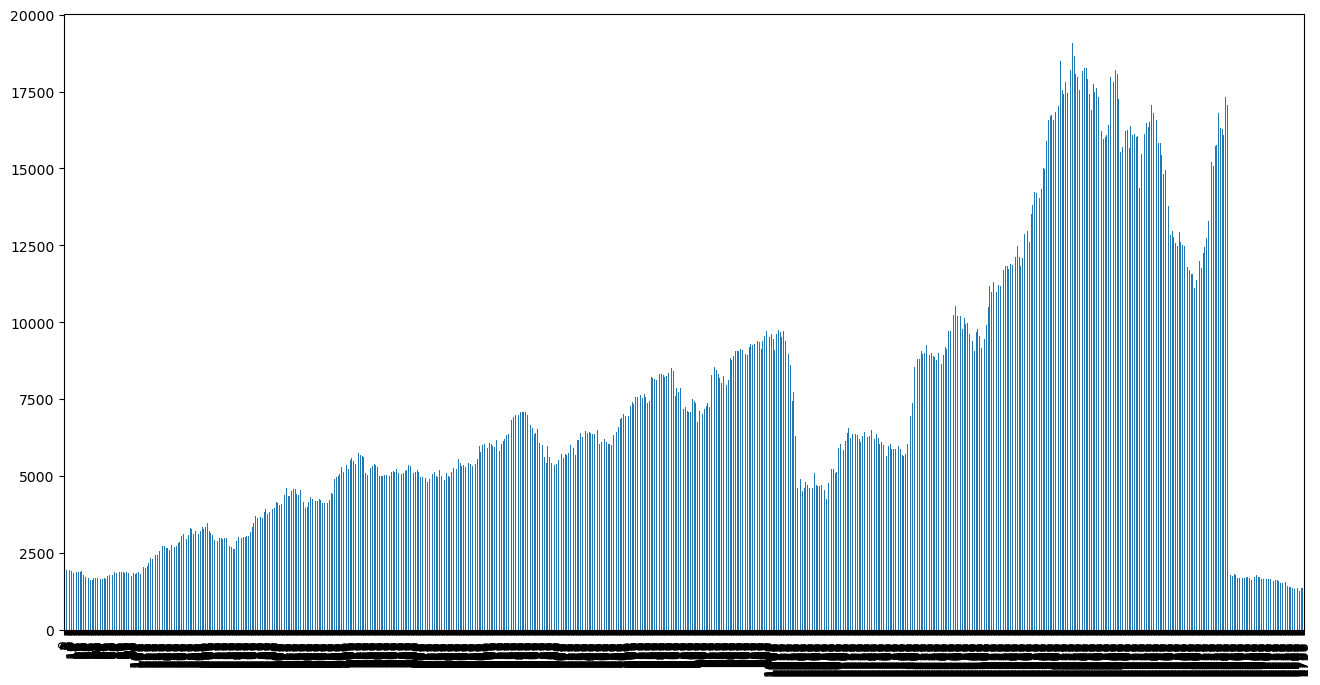

In [ ]:
df.CLOSE.plot(kind="bar", figsize=(16, 8))

In [ ]:
df.iloc[-1]


Unnamed: 0                       1758
index                          257361
SYMBOL                     BAJAJFINSV
SERIES                             EQ
OPEN                           1406.0
HIGH                          1418.65
LOW                            1394.0
CLOSE                         1401.75
TOTTRDQTY                     2069492
TOTTRDVAL                2914164346.1
TOTALTRADES                     67246
DATE              2023-02-10 00:00:00
DAY_OF_WEEK                    Friday
WEEK_NUM                            6
SMA_20_C                     1346.295
SMA_20_H                    1365.3025
SMA_44_C                  1446.242045
SMA_200_C                  7324.12425
CDL_COLOR                         red
CDL_SIZE                         4.25
TOPWICK_SIZE                    12.65
BOTWICK_SIZE                     7.75
DIFF_20_44                  99.947045
DIFF_20_200                5977.82925
DIFF_20_CLOSE                  55.455
DIFF_44_CLOSE               44.492045
DIFF_200_CLO

In [ ]:
for symbol in df500:
    file_path = base_path / processed_data_dir / f"{symbol}.csv"
    if file_path.exists():
        df = pd.read_csv(file_path, parse_dates=["DATE"])
        # Convert daily data to monthly data
        df_monthly = df.resample("M", on="DATE").agg(
            {
                "OPEN": "first",
                "HIGH": "max",
                "LOW": "min",
                "CLOSE": "last",
                "SYMBOL": "first",
            }
        )

        # check_historical_minmax(df, min_steps_back=30, mode="max")
        check_historical_minmax(df_monthly, min_steps_back=36, mode="all")

In [ ]:
# Get list of all csv files in raw_data_dir
# csv_files = [f for f in raw_data_dir.iterdir() if f.suffix == '.csv']

# for file in csv_files:
#     file_path = base_path / processed_data_dir / f"{symbol}.csv"
#     if os.path.exists(file_path):
#         df = pd.read_csv(file_path, parse_dates=["DATE"])

#         # Convert daily data to monthly data
#         df_monthly = df.resample('M', on='DATE').agg({'OPEN': 'first', 'HIGH': 'max', 'LOW': 'min', 'CLOSE': 'last','SYMBOL': 'first'})

#         # check_historical_minmax(df, min_steps_back=300, mode="max")
#         check_historical_minmax(df_monthly, min_steps_back=60, mode="max")

Movement in a band

In [ ]:
def check_movement_within_band(df, band_perc=5, steps_lookback=20):
    steps_lookback = min(steps_lookback + 1, df.shape[0])
    max_steps = len(df)

    band_max = df.CLOSE.iloc[-1] * (1 + band_perc / 100)
    band_min = df.CLOSE.iloc[-1] * (1 - band_perc / 100)

    in_band = True
    steps_back = 1
    while in_band:
        steps_back += 1
        if steps_back > max_steps:
            print(
                f"{df.SYMBOL.iloc[-1]}: Within band of {band_perc}% for {steps_back-1} sessions for band: {band_min:0.2f} to {band_max:0.2f}"
            )
            return
        in_band = (df.CLOSE.iloc[-steps_back] <= band_max) and (
            df.CLOSE.iloc[-steps_back] >= band_min
        )

    if steps_back >= steps_lookback:
        print(
            f"{df.SYMBOL.iloc[-1]} CLOSE -> {df.CLOSE.iloc[-1]} : Within band of {band_perc}% for {steps_back-1} sessions for band: {band_min:0.2f} to {band_max:0.2f}"
        )
        return

In [ ]:
# symbol = "VAIBHAVGBL"
# file_path = base_path / processed_data_dir / f"{symbol}.csv"
# if not os.path.exists(file_path):
#     print(f"File does not exist: {file_path}")
# else:
#     print(f"File exists: {file_path}")
#     df = pd.read_csv(file_path, parse_dates=["DATE"])
#     df = df.query("DATE < '2022-08-27'")
#     check_movement_within_band(df, band_perc=5, steps_lookback=20)

# Convert daily data to monthly data
# df_monthly = df.resample('M', on='DATE').agg({'OPEN': 'first', 'HIGH': 'max', 'LOW': 'min', 'CLOSE': 'last','SYMBOL': 'first'})

In [ ]:
# for symbol in df500:
#     file_path = base_path / processed_data_dir / f"{symbol}.csv"
#     if os.path.exists(file_path):
#         df = pd.read_csv(file_path, parse_dates=["DATE"])

#         check_movement_within_band(df, band_perc=3, steps_lookback=20)

In [ ]:
# def check_3_green_on_SMA(df, sma_period=20):

#     if df.shape[0] < sma_period:
#         return

#     if all([
#         df.OPEN.iloc[-3] < df.SMA_20_C.iloc[-3] < df.CLOSE.iloc[-3],
#         df.OPEN.iloc[-2] < df.CLOSE.iloc[-2],
#         df.OPEN.iloc[-1] < df.CLOSE.iloc[-1],
#         df.CLOSE.iloc[-1] > df.CLOSE.iloc[-2] > df.CLOSE.iloc[-3],
#     ]): # 3 green candles on SMA

#         print(f"{df.SYMBOL.iloc[-1]}: 3 green candles on SMA 20 on {df.DATE.iloc[-1]}")

In [ ]:
# Get list of all csv files in raw_data_dir
# csv_files = [f for f in os.listdir(processed_data_dir) if f.endswith('.csv')]

# for file in csv_files:
#     file_path = base_path / processed_data_dir / f"{symbol}.csv"
#     if os.path.exists(file_path):
#         df = pd.read_csv(file_path, parse_dates=["DATE"])

#         # Convert daily data to monthly data
#         # df_monthly = df.resample('M', on='DATE').agg({'OPEN': 'first', 'HIGH': 'max', 'LOW': 'min', 'CLOSE': 'last','SYMBOL': 'first'})

#         # Convert daily data to weekly data
#         df_weekly = df.resample('W', on='DATE').agg({'OPEN': 'first', 'HIGH': 'max', 'LOW': 'min', 'CLOSE': 'last','SYMBOL': 'first'})
#         df_weekly['SMA_20_C'] = df_weekly.CLOSE.rolling(20).mean()
#         if "DATE" not in df_weekly.columns:
#             df_weekly["DATE"] = df_weekly.index

#         check_3_green_on_SMA(df_weekly, sma_period=20)

In [ ]:
# Download csv from URL
# url = r"https://www.nseindia.com/api/equity-stockIndices?csv=true&index=SECURITIES%20IN%20F%26O"
# df = pd.read_csv(url)
# df


In [ ]:
# import requests
# # Download csv from URL using requests
# url = r"https://www.nseindia.com/api/equity-stockIndices?csv=true&index=SECURITIES%20IN%20F%26O"
# requests.get(url).content


In [ ]:
# https://www.nseindia.com/market-data/live-equity-market

# https://www.nseindia.com/api/equity-stockIndices?csv=true&index=NIFTY%20SMALLCAP%2050


In [ ]:
# init_cap = 200000
# win_rate = 0.6
# one_trade_perc = 0.02

# for i in range(200):
#     if random.random() < win_rate:
#         init_cap = init_cap * (1 + one_trade_perc)
#     else:
#         init_cap = init_cap * (1 - one_trade_perc)

# print(f'{init_cap:,}')

In [ ]:
# import random
# random.random()

In [ ]:
# | hide
nbdev.nbdev_export()